# ❤️ Task 3 — Heart Disease Prediction (Using Uploaded Dataset)

**Dataset file:** `/mnt/data/heart_disease_uci.csv`  
Detected target column: **num**

**Goal:** Predict heart disease risk (binary classification) with Logistic Regression & Decision Tree.

**This notebook auto-detects the target column and handles categorical features with one-hot encoding.**

## ✅ What this covers
- Load the provided CSV and inspect schema
- Clean/prepare data (missing values, type handling)
- EDA: summary, distributions, correlations
- Train two models: Logistic Regression & Decision Tree
- Evaluate with Accuracy, ROC-AUC, Confusion Matrix, ROC curve
- Feature importance (LR coefficients & Tree importances)


In [21]:

# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, classification_report

# Config for plots
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.dpi'] = 120

CSV_PATH = r"C:\Users\Hp\Downloads\heart_disease_uci.csv"
TARGET_CANDIDATES = ['target', 'num', 'output', 'disease', 'condition', 'hd', 'class', 'diagnosis']


In [22]:

# Load dataset
df = pd.read_csv(CSV_PATH)
print("Shape:", df.shape)
print("Columns:", list(df.columns))
display(df.head())


Shape: (920, 16)
Columns: ['id', 'age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


## 🧹 Cleaning & Target Preparation
- Detect/confirm target column
- Convert multi-class targets (e.g., `num` with 0–4) into binary (1 = disease, 0 = no disease)
- Handle missing values (drop rows if minimal; otherwise could impute)


In [23]:

# Detect target column
target_col = None
for c in TARGET_CANDIDATES:
    if c in df.columns:
        target_col = c
        break
if target_col is None:
    target_col = df.columns[-1]  # fallback to last column
print("Using target column:", target_col)

# Basic missing values report
print("\nMissing values per column:")
print(df.isna().sum())

# Try to coerce non-numeric categories to string for later one-hot
for c in df.columns:
    if df[c].dtype == 'object':
        df[c] = df[c].astype(str)

# Convert target to binary if needed
y_raw = df[target_col]
# Heuristics:
# - If numeric with values >1, binarize: y = 1 if value > 0 else 0
# - If string, map common labels
if np.issubdtype(y_raw.dtype, np.number):
    y = (y_raw.values > 0).astype(int)
else:
    y = y_raw.str.lower().map({
        '1':1,'0':0,'yes':1,'no':0,'true':1,'false':0,'presence':1,'absence':0,
        'disease':1,'healthy':0,'present':1,'absent':0
    })
    # Fallback: if mapping yields many NaNs, try equality to '1'
    if y.isna().mean() > 0.4:
        y = (y_raw == '1').astype(int)

# Drop target from features
X = df.drop(columns=[target_col])

# Drop rows with missing in either X or y (simple strategy for clean baseline)
mask = pd.notna(y)
X = X.loc[mask].copy()
y = y[mask].astype(int)

# Report final shapes
print("Final shapes -> X:", X.shape, "| y:", y.shape)
display(X.head())
print("Target distribution (0=no disease, 1=disease):")
print(pd.Series(y).value_counts())


Using target column: num

Missing values per column:
id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64
Final shapes -> X: (920, 15) | y: (920,)


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal


Target distribution (0=no disease, 1=disease):
1    509
0    411
Name: count, dtype: int64


## 📊 EDA (Quick)
- Numeric summary (`describe`)
- Histograms for numeric features
- Correlation heatmap for numeric features
*Note: Using matplotlib only for plotting.*

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal
count,920.000000,920.000000,920,920,920,861.000000,890.000000,920,920,865.000000,920,858.000000,920,309.000000,920
unique,NaN,NaN,2,4,4,NaN,NaN,3,4,NaN,3,NaN,4,NaN,4
top,NaN,NaN,Male,Cleveland,asymptomatic,NaN,NaN,False,normal,NaN,False,NaN,flat,NaN,nan
freq,NaN,NaN,726,304,496,NaN,NaN,692,551,NaN,528,NaN,345,NaN,486
mean,460.500000,53.510870,NaN,NaN,NaN,132.132404,199.130337,NaN,NaN,137.545665,NaN,0.878788,NaN,0.676375,NaN
std,265.725422,9.424685,NaN,NaN,NaN,19.066070,110.780810,NaN,NaN,25.926276,NaN,1.091226,NaN,0.935653,NaN
min,1.000000,28.000000,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,60.000000,NaN,-2.600000,NaN,0.000000,NaN
25%,230.750000,47.000000,NaN,NaN,NaN,120.000000,175.000000,NaN,NaN,120.000000,NaN,0.000000,NaN,0.000000,NaN
50%,460.500000,54.000000,NaN,NaN,NaN,130.000000,223.000000,NaN,NaN,140.000000,NaN,0.500000,NaN,0.000000,NaN
75%,690.250000,60.000000,NaN,NaN,NaN,140.000000,268.000000,NaN,NaN,157.000000,NaN,1.500000,NaN,1.000000,NaN


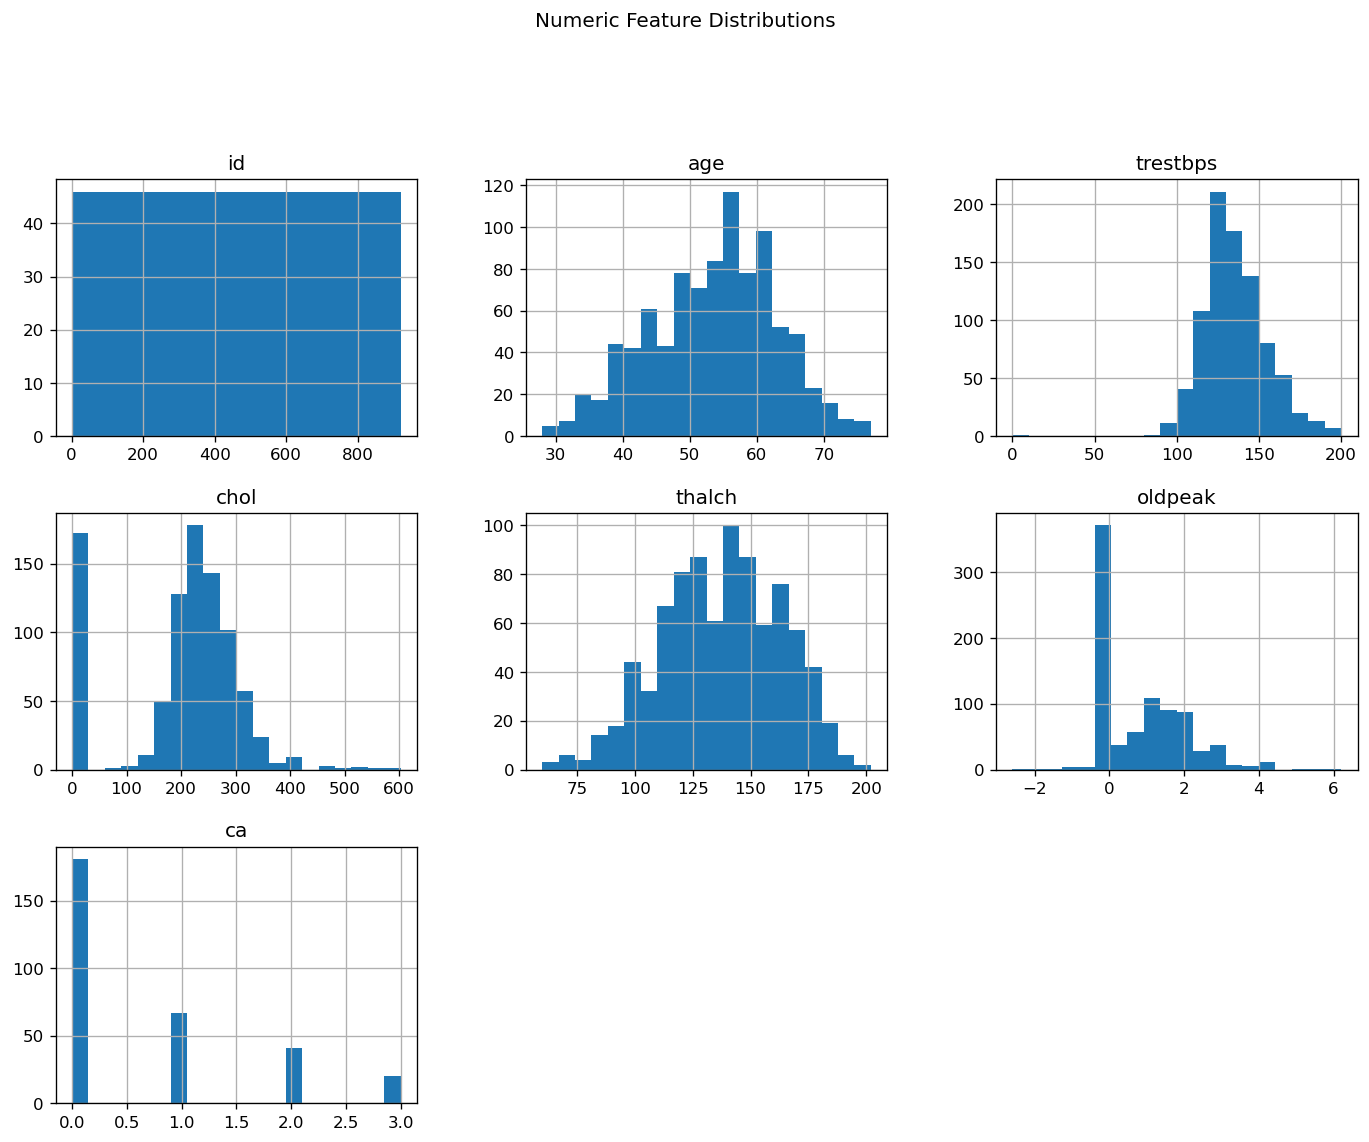

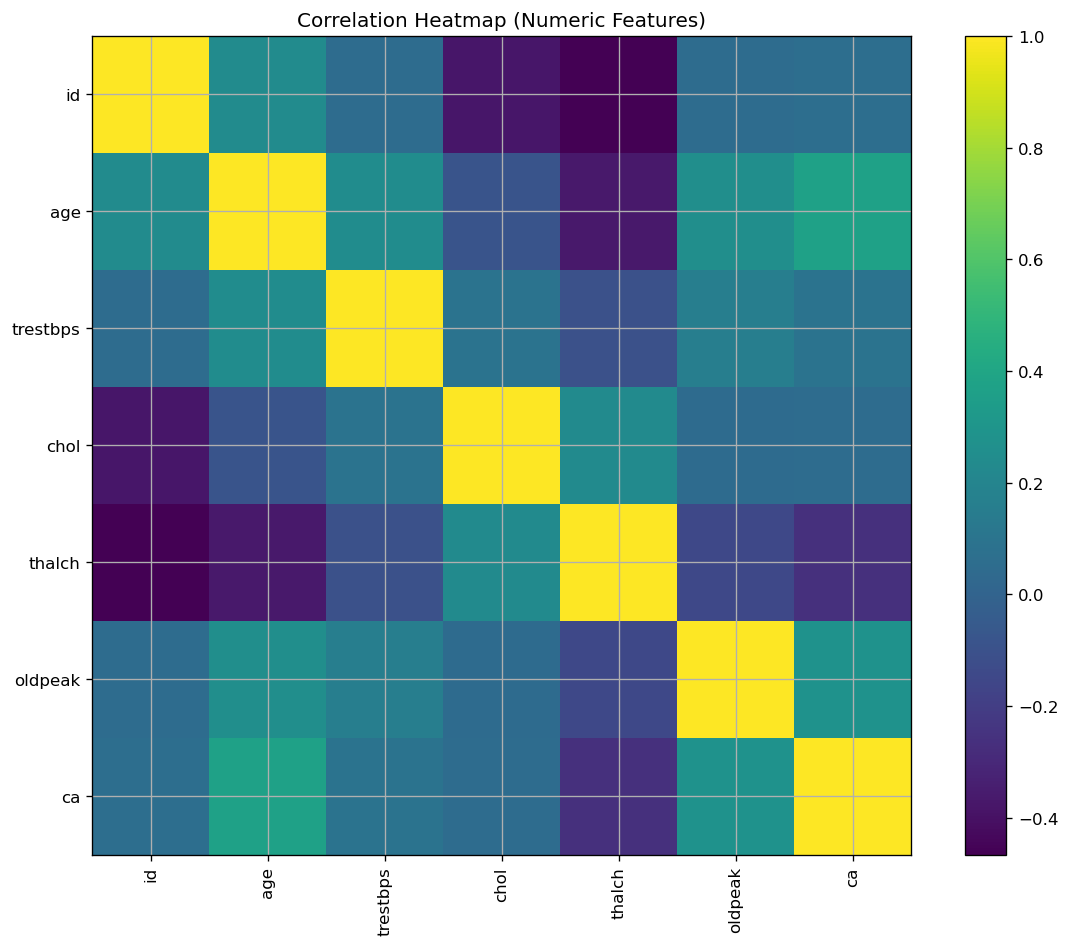

In [24]:

# Summary stats
display(X.describe(include='all'))

# Separate numeric and categorical columns
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

# Histograms for numeric features
if len(num_cols) > 0:
    X[num_cols].hist(bins=20, figsize=(14,10))
    plt.suptitle("Numeric Feature Distributions", y=1.02)
    plt.show()

# Correlation heatmap for numeric features
if len(num_cols) > 1:
    corr = X[num_cols].corr()
    fig, ax = plt.subplots(figsize=(10,8))
    cax = ax.imshow(corr, interpolation='nearest')
    ax.set_title("Correlation Heatmap (Numeric Features)")
    fig.colorbar(cax)
    ax.set_xticks(range(len(num_cols)))
    ax.set_xticklabels(num_cols, rotation=90)
    ax.set_yticks(range(len(num_cols)))
    ax.set_yticklabels(num_cols)
    plt.tight_layout()
    plt.show()


## ✂️ Train/Test Split
- 80% training, 20% testing
- Stratified by target to maintain class balance

In [25]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(736, 15) (184, 15) (736,) (184,)


## 🤖 Models & Pipelines
- **Logistic Regression** with scaling for numeric features and one-hot encoding for categorical
- **Decision Tree** with one-hot encoding for categoricals (no scaling needed)
- We’ll evaluate Accuracy and ROC-AUC, plus Confusion Matrix and ROC curve plots


=== Logistic Regression ===
Accuracy: 0.864 | ROC-AUC: 0.933
              precision    recall  f1-score   support

           0      0.880     0.805     0.841        82
           1      0.853     0.912     0.882       102

    accuracy                          0.864       184
   macro avg      0.867     0.858     0.861       184
weighted avg      0.865     0.864     0.863       184


=== Decision Tree ===
Accuracy: 0.853 | ROC-AUC: 0.924
              precision    recall  f1-score   support

           0      0.887     0.768     0.824        82
           1      0.832     0.922     0.874       102

    accuracy                          0.853       184
   macro avg      0.860     0.845     0.849       184
weighted avg      0.857     0.853     0.852       184



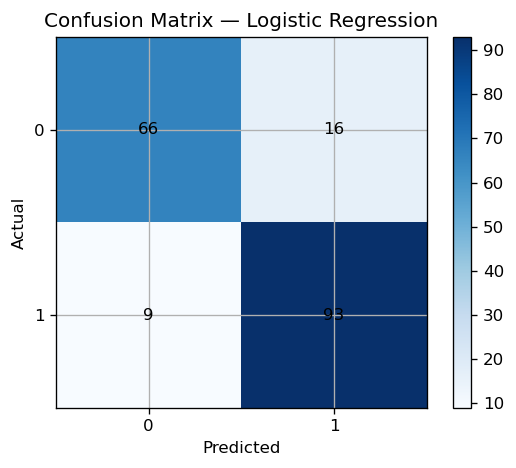

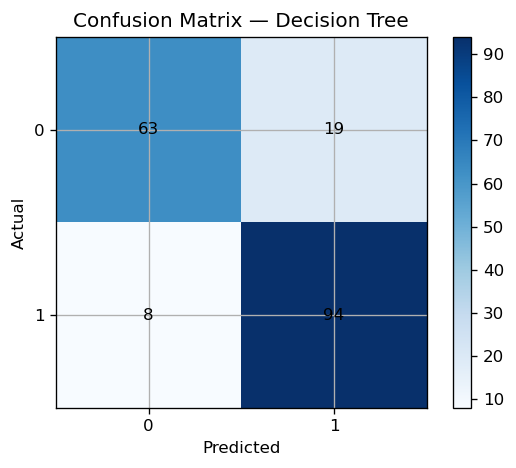

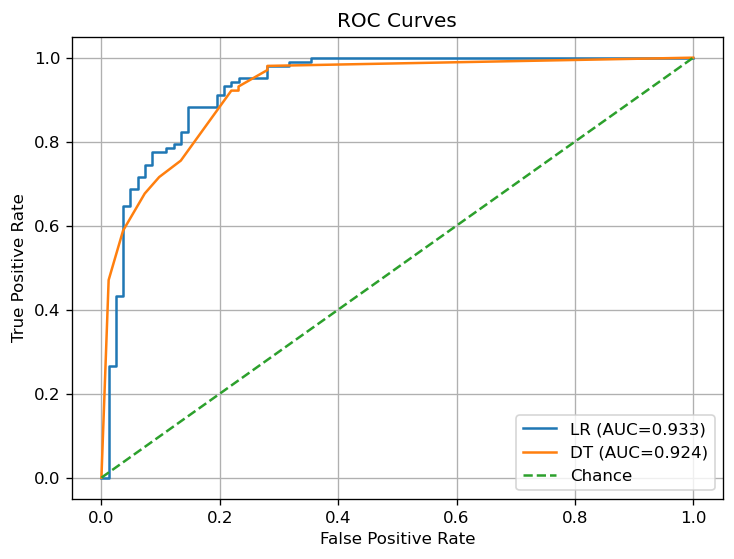

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, roc_curve
from sklearn.impute import SimpleImputer

# ==== Split data ====
X = df.drop(['num'], axis=1)
y = df['num'].apply(lambda x: 1 if x > 0 else 0)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ==== Column types ====
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]

# ==== Transformers ====
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ],
    remainder='drop'
)

# ==== Pipelines ====
lr_pipe = Pipeline(steps=[
    ('prep', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, solver='liblinear'))
])

dt_pipe = Pipeline(steps=[
    ('prep', preprocessor),
    ('clf', DecisionTreeClassifier(max_depth=4, random_state=42))
])

# ==== Fit models ====
lr_pipe.fit(X_train, y_train)
dt_pipe.fit(X_train, y_train)

# ==== Predictions & Probabilities ====
lr_pred = lr_pipe.predict(X_test)
dt_pred = dt_pipe.predict(X_test)
lr_proba = lr_pipe.predict_proba(X_test)[:, 1]
dt_proba = dt_pipe.predict_proba(X_test)[:, 1]

# ==== Metrics Function ====
def report(name, y_true, y_hat, proba):
    acc = accuracy_score(y_true, y_hat)
    auc = roc_auc_score(y_true, proba)
    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")
    print(classification_report(y_true, y_hat, digits=3))
    return acc, auc

lr_acc, lr_auc = report('Logistic Regression', y_test, lr_pred, lr_proba)
dt_acc, dt_auc = report('Decision Tree', y_test, dt_pred, dt_proba)

# ==== Confusion Matrices ====
def plot_confusion(cm, title):
    fig, ax = plt.subplots(figsize=(5, 4))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['0', '1'])
    ax.set_yticklabels(['0', '1'])
    # Annotate cells
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha='center', va='center', color="black")
    plt.tight_layout()
    plt.show()

cm_lr = confusion_matrix(y_test, lr_pred)
cm_dt = confusion_matrix(y_test, dt_pred)
plot_confusion(cm_lr, "Confusion Matrix — Logistic Regression")
plot_confusion(cm_dt, "Confusion Matrix — Decision Tree")

# ==== ROC Curves ====
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_proba)
fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_proba)

plt.figure(figsize=(7, 5))
plt.plot(fpr_lr, tpr_lr, label=f'LR (AUC={lr_auc:.3f})')
plt.plot(fpr_dt, tpr_dt, label=f'DT (AUC={dt_auc:.3f})')
plt.plot([0, 1], [0, 1], '--', label='Chance')
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


## 🌟 Feature Importance
- For **Logistic Regression**, we inspect standardized coefficients.
- For **Decision Tree**, we use `feature_importances_`.
- We map transformed feature names back to original columns (including one-hot categories).

In [32]:

# Recover transformed feature names
prep = lr_pipe.named_steps['prep']
feature_names = []
if len(prep.transformers_) > 0:
    # numeric
    num_features = prep.transformers_[0][2] if len(prep.transformers_)>0 else []
    feature_names.extend(num_features)
    # categorical
    if len(prep.transformers_)>1 and hasattr(prep.transformers_[1][1], 'get_feature_names_out'):
        ohe = prep.transformers_[1][1]
        ohe_names = ohe.get_feature_names_out(prep.transformers_[1][2])
        feature_names = list(num_features) + list(ohe_names)
feature_names = list(feature_names)

# LR Coefficients
lr_coef = lr_pipe.named_steps['clf'].coef_.flatten()
lr_imp = pd.Series(lr_coef, index=feature_names)
lr_imp_sorted = lr_imp.reindex(lr_imp.abs().sort_values(ascending=False).index)

# DT Importances
dt_imp = pd.Series(dt_pipe.named_steps['clf'].feature_importances_, index=feature_names)
dt_imp_sorted = dt_imp.sort_values(ascending=False)

# Show top features
print("\nTop 10 LR (by |coef|):")
display(lr_imp_sorted.head(10).to_frame('coefficient'))
print("\nTop 10 DT (by importance):")
display(dt_imp_sorted.head(10).to_frame('importance'))



Top 10 LR (by |coef|):


,coefficient
dataset_VA Long Beach,-1.671973
id,1.594110
dataset_Cleveland,1.141902
cp_asymptomatic,0.954130
dataset_Switzerland,0.929338
cp_atypical angina,-0.793396
ca,0.631785
slope_flat,0.624208
thal_reversable defect,0.601994
sex_Female,-0.523879



Top 10 DT (by importance):


,importance
id,0.516886
ca,0.231077
thal_reversable defect,0.072265
thal_normal,0.039704
oldpeak,0.032835
cp_asymptomatic,0.031484
sex_Male,0.026039
age,0.025751
trestbps,0.007503
chol,0.007156


## ✅ Insights & Next Steps
- Logistic Regression provides a strong linear baseline; Decision Tree captures some non-linearities.
- Consider cross-validation, regularization (C/L1/L2) tuning for LR, and depth/min_samples tuning for DT.
- Try ensemble methods (RandomForest, XGBoost), and calibration for probabilities.
- Validate fairness and avoid data leakage; consult clinical guidance for interpretation.
